In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner
import random
from tensorflow.keras.preprocessing import image
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# Directorios de datos
RUTA_DATOS_ENTRENAMIENTO = '/workspaces/LungsXray-FP/Imagenes_entrenamiento_testeo_binario_y_fine_tuning/Imagenes_fine_tuning/entrenamiento'
RUTA_DATOS_VALIDACION = '/workspaces/LungsXray-FP/Imagenes_entrenamiento_testeo_binario_y_fine_tuning/Imagenes_fine_tuning/validacion'
RUTA_DATOS_TESTEO = '/workspaces/LungsXray-FP/Imagenes_entrenamiento_testeo_binario_y_fine_tuning/Imagenes_fine_tuning/testeo'

In [3]:
# Configuración de parámetros
BATCH_SIZE = 32
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
# Utilidad para cargar imágenes y etiquetas automáticamente
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Cargar y etiquetar automáticamente las imágenes utilizando el nombre de las subcarpetas
train_data_flow = data_generator.flow_from_directory(
    RUTA_DATOS_ENTRENAMIENTO,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_data_flow = data_generator.flow_from_directory(
    RUTA_DATOS_VALIDACION,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_data_flow = data_generator.flow_from_directory(
    RUTA_DATOS_TESTEO,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4152 images belonging to 4 classes.


Found 889 images belonging to 4 classes.
Found 891 images belonging to 4 classes.


In [5]:
# Número total de clases
NUM_CLASSES = len(train_data_flow.class_indices)

In [10]:
def cargar_modelo_preentrenado(ruta_modelo, nombre):
    modelo = load_model(ruta_modelo)
    # Verificar si es un modelo secuencial y convertirlo a funcional si es necesario
    if isinstance(modelo, tf.keras.Sequential):
        inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
        modelo = tf.keras.Model(inputs=inputs, outputs=modelo(inputs))
    modelo._name = nombre
    return modelo

In [22]:
# Función principal para construir el modelo
def construir_modelo(hp, optimizer='adam', loss='categorical_crossentropy'):
    # Cargar modelos preentrenados
    modelo_covid = cargar_modelo_preentrenado('/workspaces/LungsXray-FP/Codigos_y_modelos_Krisztian/Modelos_binarios/covid', 'm1')
    modelo_normal = cargar_modelo_preentrenado('/workspaces/LungsXray-FP/Codigos_y_modelos_Krisztian/Modelos_binarios/normal', 'm2')
    modelo_pneumonia = cargar_modelo_preentrenado('/workspaces/LungsXray-FP/Codigos_y_modelos_Krisztian/Modelos_binarios/pneumonia', 'm3')
    modelo_tuberculosis = cargar_modelo_preentrenado('/workspaces/LungsXray-FP/Codigos_y_modelos_Krisztian/Modelos_binarios/tuberculosis', 'm4')

    # Descongelar los pesos de los modelos preentrenados
    for modelo in [modelo_covid, modelo_normal, modelo_pneumonia, modelo_tuberculosis]:
        modelo.trainable = True

    # Entrada compartida
    input_layer = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    output_covid = modelo_covid(input_layer)
    output_normal = modelo_normal(input_layer)
    output_pneumonia = modelo_pneumonia(input_layer)
    output_tuberculosis = modelo_tuberculosis(input_layer)

    # Combinar las salidas de los modelos preentrenados
    merged_output = tf.keras.layers.Concatenate(axis=-1)([output_covid, output_normal, output_pneumonia, output_tuberculosis])

    # Capas densas adicionales para la clasificación multiclase    
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1)
    units_per_layer = hp.Int('units_per_layer', min_value=32, max_value=128, step=32)

    for _ in range(num_hidden_layers):
        merged_output = Dense(units_per_layer, activation='relu')(merged_output)

    # Capas densas adicionales para la clasificación multiclase    
    merged_output = Dense(hp.Int('dense_1_units', min_value=32, max_value=128, step=32), activation='relu')(merged_output)
    #merged_output = Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1))(merged_output)
    merged_output = Dense(hp.Int('dense_2_units', min_value=32, max_value=128, step=32), activation='relu')(merged_output)
    merged_output = Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1))(merged_output)

    # Capa de salida para la predicción
    output_layer = Dense(NUM_CLASSES, activation='softmax')(merged_output)

    # Crear el modelo final
    modelo_final = Model(inputs=input_layer, outputs=output_layer)

    # Compilar el modelo con la tasa de aprendizaje
    modelo_final.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return modelo_final

In [38]:
# Configuración del sintonizador
tuner = keras_tuner.RandomSearch(
    construir_modelo,
    objective='val_accuracy',
    max_trials=10,
    directory='C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning',
    project_name='Enfermedades_random'
)

Reloading Tuner from C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning\Enfermedades_random\tuner0.json


In [9]:
# Implementar EarlyStopping para detener el entrenamiento si no mejora la métrica de validación
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [10]:
# Búsqueda de los mejores hiperparámetros

tuner.search(train_data_flow, epochs=10 , validation_data=validation_data_flow)

Trial 10 Complete [00h 51m 24s]
val_accuracy: 0.7975252866744995

Best val_accuracy So Far: 0.834645688533783
Total elapsed time: 08h 29m 51s


In [11]:
# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

In [12]:
# Obtener los mejores hiperparámetros
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

{'num_hidden_layers': 3, 'units_per_layer': 128, 'dense_1_units': 64, 'dense_2_units': 128, 'dropout_2': 0.1}


In [64]:
# Implementar EarlyStopping para detener el entrenamiento si no mejora la métrica de validación
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Implementar ModelCheckpoint para guardar el mejor modelo durante el entrenamiento
checkpoint_filepath = 'C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos/random'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [65]:
#Entrenar el mejor modelo con los datos del generador, agregar regularización y ajustar pesos de clase
history = best_model.fit(
    train_data_flow,
    epochs=50,  # Ajusta según sea necesario
    validation_data=validation_data_flow,
    callbacks=[early_stopping, model_checkpoint_callback]
    )  

Epoch 1/50
130/130 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.8066INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


130/130 [==============================] - 331s 3s/step - loss: 0.6732 - accuracy: 0.8066 - val_loss: 0.6647 - val_accuracy: 0.7930
Epoch 2/50
130/130 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.8054INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


130/130 [==============================] - 330s 3s/step - loss: 0.6818 - accuracy: 0.8054 - val_loss: 0.6800 - val_accuracy: 0.8144
Epoch 3/50
130/130 [==============================] - ETA: 0s - loss: 0.6487 - accuracy: 0.8182INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


130/130 [==============================] - 318s 2s/step - loss: 0.6487 - accuracy: 0.8182 - val_loss: 0.6068 - val_accuracy: 0.8403
Epoch 4/50
130/130 [==============================] - 321s 2s/step - loss: 0.6499 - accuracy: 0.8174 - val_loss: 0.6042 - val_accuracy: 0.8279
Epoch 5/50
130/130 [==============================] - 320s 2s/step - loss: 0.6792 - accuracy: 0.8054 - val_loss: 0.6885 - val_accuracy: 0.7930
Epoch 6/50
130/130 [==============================] - 316s 2s/step - loss: 0.7102 - accuracy: 0.7801 - val_loss: 0.6981 - val_accuracy: 0.7829
Epoch 7/50
130/130 [==============================] - 311s 2s/step - loss: 0.6797 - accuracy: 0.7979 - val_loss: 0.7389 - val_accuracy: 0.7762
Epoch 8/50
130/130 [==============================] - 311s 2s/step - loss: 0.6617 - accuracy: 0.8102 - val_loss: 0.5988 - val_accuracy: 0.8369
Epoch 9/50
130/130 [==============================] - 311s 2s/step - loss: 0.6557 - accuracy: 0.8133 - val_loss: 0.6221 - val_accuracy: 0.8245
Epoch 10/5

INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


130/130 [==============================] - 310s 2s/step - loss: 0.6306 - accuracy: 0.8201 - val_loss: 0.5788 - val_accuracy: 0.8459
Epoch 12/50
130/130 [==============================] - 309s 2s/step - loss: 0.6074 - accuracy: 0.8297 - val_loss: 0.6568 - val_accuracy: 0.7998
Epoch 13/50
130/130 [==============================] - 312s 2s/step - loss: 0.6281 - accuracy: 0.8244 - val_loss: 0.5983 - val_accuracy: 0.8369
Epoch 14/50
130/130 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.8215INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


130/130 [==============================] - 324s 2s/step - loss: 0.6277 - accuracy: 0.8215 - val_loss: 0.5793 - val_accuracy: 0.8515
Epoch 15/50
130/130 [==============================] - 301s 2s/step - loss: 0.6349 - accuracy: 0.8251 - val_loss: 0.6736 - val_accuracy: 0.8211
Epoch 16/50
130/130 [==============================] - 314s 2s/step - loss: 0.6220 - accuracy: 0.8247 - val_loss: 0.6327 - val_accuracy: 0.8020
Epoch 17/50
130/130 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.8235INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


130/130 [==============================] - 322s 2s/step - loss: 0.6290 - accuracy: 0.8235 - val_loss: 0.5491 - val_accuracy: 0.8650
Epoch 18/50
130/130 [==============================] - 310s 2s/step - loss: 0.6094 - accuracy: 0.8256 - val_loss: 0.5927 - val_accuracy: 0.8369
Epoch 19/50
130/130 [==============================] - 301s 2s/step - loss: 0.6148 - accuracy: 0.8292 - val_loss: 0.5616 - val_accuracy: 0.8425
Epoch 20/50
130/130 [==============================] - 311s 2s/step - loss: 0.5949 - accuracy: 0.8384 - val_loss: 0.5745 - val_accuracy: 0.8448
Epoch 21/50
130/130 [==============================] - 311s 2s/step - loss: 0.5825 - accuracy: 0.8473 - val_loss: 0.6678 - val_accuracy: 0.8346
Epoch 22/50
130/130 [==============================] - 312s 2s/step - loss: 0.6296 - accuracy: 0.8312 - val_loss: 0.6021 - val_accuracy: 0.8268
Epoch 23/50
130/130 [==============================] - 305s 2s/step - loss: 0.5883 - accuracy: 0.8430 - val_loss: 0.6024 - val_accuracy: 0.8324
Epoc

INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


130/130 [==============================] - 321s 2s/step - loss: 0.5937 - accuracy: 0.8413 - val_loss: 0.5131 - val_accuracy: 0.8763
Epoch 33/50
130/130 [==============================] - 311s 2s/step - loss: 0.6182 - accuracy: 0.8227 - val_loss: 0.6049 - val_accuracy: 0.8346
Epoch 34/50
130/130 [==============================] - 312s 2s/step - loss: 0.6018 - accuracy: 0.8372 - val_loss: 0.5327 - val_accuracy: 0.8661
Epoch 35/50
130/130 [==============================] - 313s 2s/step - loss: 0.5667 - accuracy: 0.8456 - val_loss: 0.6263 - val_accuracy: 0.8256
Epoch 36/50
130/130 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.8432INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


INFO:tensorflow:Assets written to: C:/Users/krisz/Desktop/LungsXray-FP-main/Prueba/tutorial-env/Fine_tuning/modelos\random\assets


130/130 [==============================] - 310s 2s/step - loss: 0.5796 - accuracy: 0.8432 - val_loss: 0.5258 - val_accuracy: 0.8796
Epoch 37/50
130/130 [==============================] - 310s 2s/step - loss: 0.5672 - accuracy: 0.8473 - val_loss: 0.5299 - val_accuracy: 0.8594
Epoch 38/50
130/130 [==============================] - 311s 2s/step - loss: 0.5812 - accuracy: 0.8355 - val_loss: 0.5297 - val_accuracy: 0.8628
Epoch 39/50
130/130 [==============================] - 312s 2s/step - loss: 0.5898 - accuracy: 0.8316 - val_loss: 0.5679 - val_accuracy: 0.8493
Epoch 40/50
130/130 [==============================] - 312s 2s/step - loss: 0.5744 - accuracy: 0.8442 - val_loss: 0.5336 - val_accuracy: 0.8650
Epoch 41/50
130/130 [==============================] - 312s 2s/step - loss: 0.5943 - accuracy: 0.8396 - val_loss: 0.6258 - val_accuracy: 0.8031
Epoch 42/50
130/130 [==============================] - 314s 2s/step - loss: 0.5741 - accuracy: 0.8449 - val_loss: 0.5105 - val_accuracy: 0.8673
Epoc

In [6]:
modelo = keras.models.load_model('/workspaces/LungsXray-FP/Codigos_y_modelos_Krisztian/Modelo_fine_tuning/random')

2024-01-23 18:48:42.498616: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16588800 exceeds 10% of free system memory.
2024-01-23 18:48:42.518653: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16588800 exceeds 10% of free system memory.
2024-01-23 18:48:42.524271: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16588800 exceeds 10% of free system memory.
2024-01-23 18:48:42.582692: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18432000 exceeds 10% of free system memory.
2024-01-23 18:48:42.606440: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18432000 exceeds 10% of free system memory.


In [18]:
modelo.save('prueba.keras')

In [67]:
test_loss, test_accuracy = modelo.evaluate(test_data_flow)

print(f"La pérdida en el conjunto de test es: {test_loss}")
print(f"La precisión en el conjunto de test es: {test_accuracy}")

28/28 [==============================] - 20s 682ms/step - loss: 0.5262 - accuracy: 0.8754
La pérdida en el conjunto de test es: 0.5261538624763489
La precisión en el conjunto de test es: 0.875420868396759


In [69]:
# Mapeo de las etiquetas numéricas a las letras correspondientes
mapeo_etiquetas = {0: 'C', 1: 'N', 2: 'P', 3: 'T'}  # Ajusta esto según tus clases

# Obtén las predicciones del modelo
predicciones = modelo.predict(test_data_flow)
predicciones = np.argmax(predicciones, axis=1)

# Obtén las etiquetas verdaderas
etiquetas_verdaderas = test_data_flow.classes

# Genera el informe de clasificación
informe = classification_report(etiquetas_verdaderas, predicciones, target_names=list(mapeo_etiquetas.values()))

print(informe)

28/28 [==============================] - 18s 589ms/step
              precision    recall  f1-score   support

           C       0.84      0.90      0.87       225
           N       0.84      0.81      0.83       141
           P       0.92      0.92      0.92       365
           T       0.83      0.79      0.81       160

    accuracy                           0.87       891
   macro avg       0.86      0.85      0.86       891
weighted avg       0.87      0.87      0.87       891



28/28 [==============================] - 16s 566ms/step


Text(95.72222222222221, 0.5, 'Verdadero')

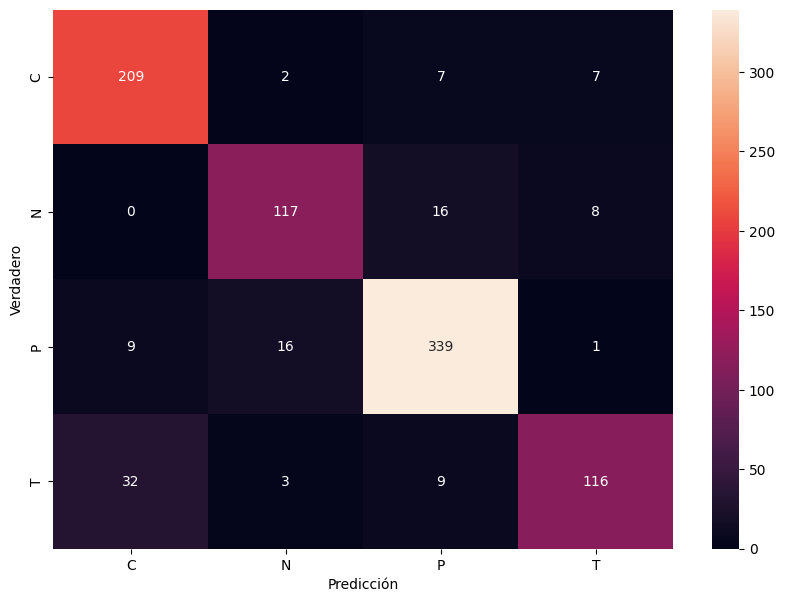

In [70]:
# Obtén las predicciones del modelo
predicciones = modelo.predict(test_data_flow)
predicciones = np.argmax(predicciones, axis=1)

# Mapea las predicciones a las letras correspondientes
predicciones = [mapeo_etiquetas[prediccion] for prediccion in predicciones]

# Obtén las etiquetas verdaderas
etiquetas_verdaderas = test_data_flow.classes

# Mapea las etiquetas verdaderas a las letras correspondientes
etiquetas_verdaderas = [mapeo_etiquetas[etiqueta] for etiqueta in etiquetas_verdaderas]

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_verdaderas, predicciones)

# Dibuja la matriz de confusión como un mapa de calor
plt.figure(figsize=(10,7))
sns.heatmap(matriz_confusion, annot=True, fmt='d', xticklabels=mapeo_etiquetas.values(), yticklabels=mapeo_etiquetas.values())
plt.xlabel('Predicción')
plt.ylabel('Verdadero')

In [58]:
modelo_covid = load_model('/workspaces/LungsXray-FP/Codigos_y_modelos_Krisztian/Codigo_fine_tuning/modelo_covid.keras')
modelo_normal = load_model('/workspaces/LungsXray-FP/Codigos_y_modelos_Krisztian/Codigo_fine_tuning/modelo_normal.keras')
modelo_pneumonia = load_model('/workspaces/LungsXray-FP/Codigos_y_modelos_Krisztian/Codigo_fine_tuning/modelo_pneumonia.keras')
modelo_tuberculosis = load_model('/workspaces/LungsXray-FP/Codigos_y_modelos_Krisztian/Codigo_fine_tuning/modelo_tuberculosis.keras')

1/1 [==============================] - 0s 21ms/step


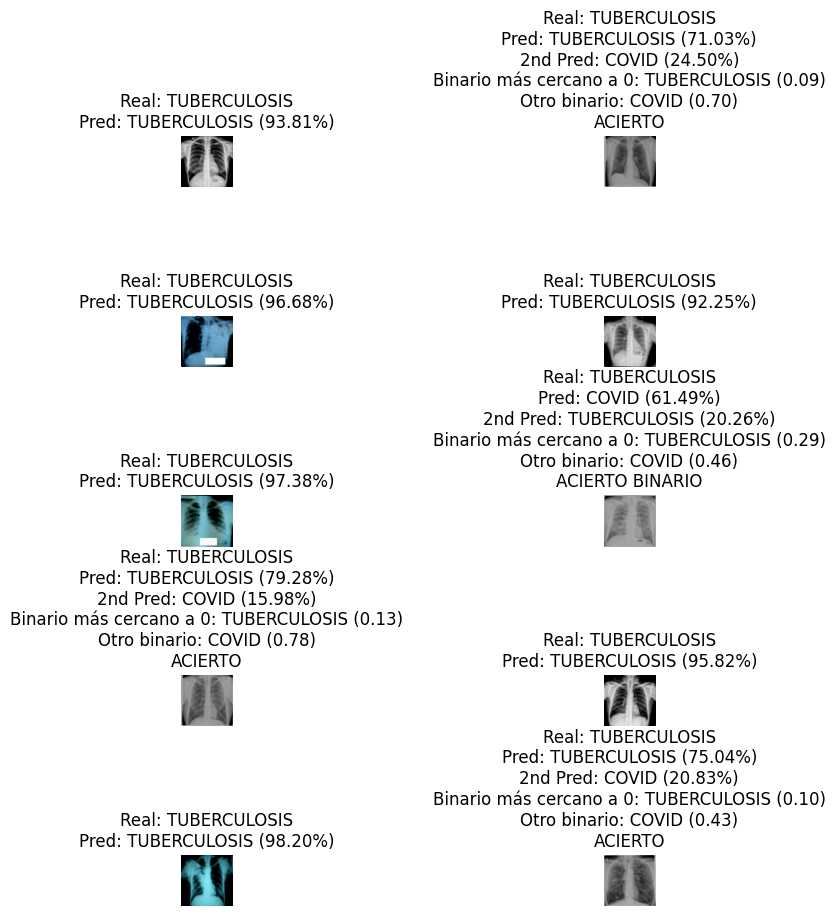

1/1 [==============================] - 0s 59ms/step


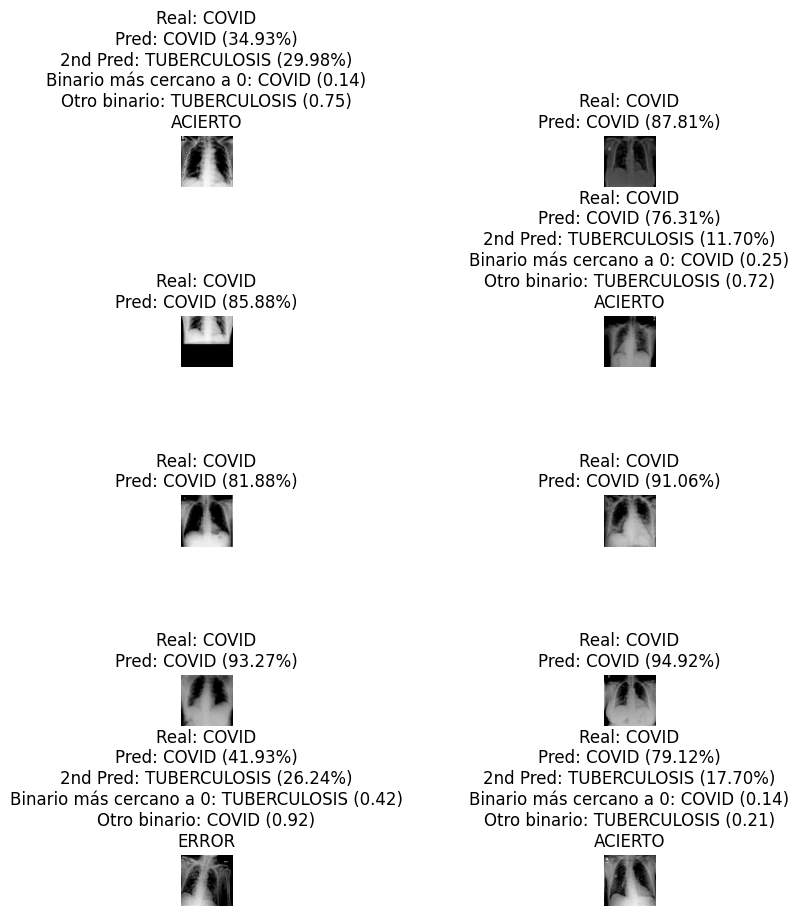

1/1 [==============================] - 0s 25ms/step


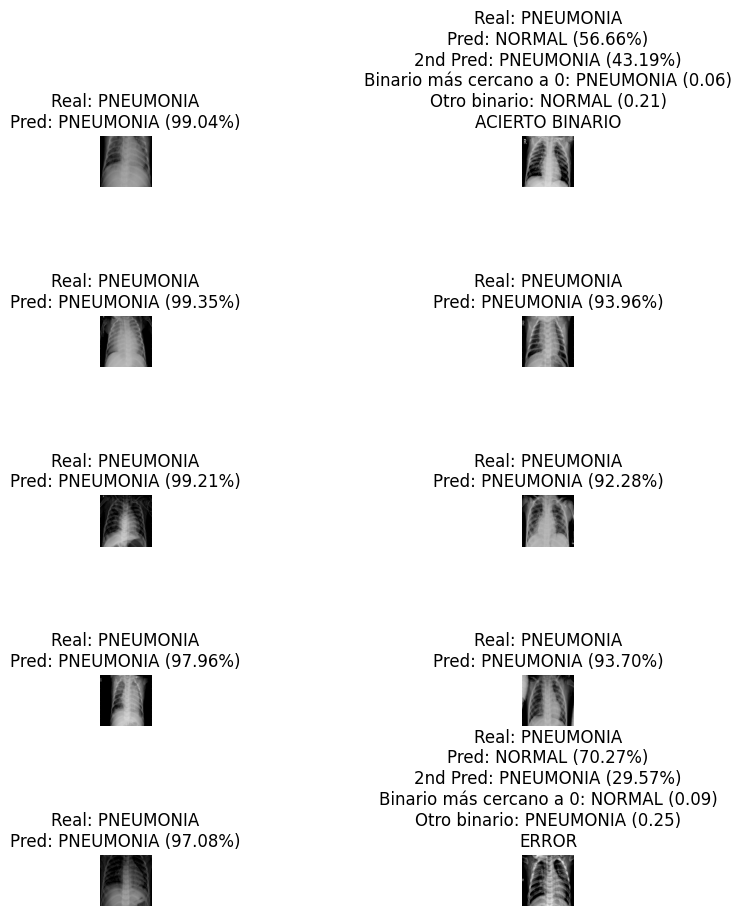

1/1 [==============================] - 0s 79ms/step


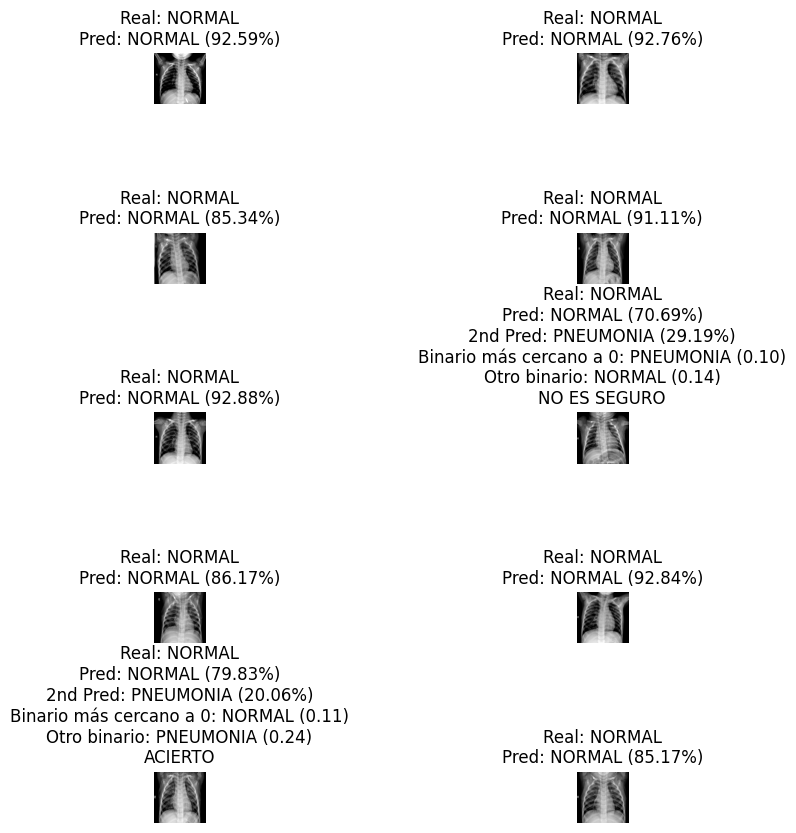

In [74]:
modelos_binarios = {'COVID': modelo_covid, 'NORMAL': modelo_normal, 'PNEUMONIA': modelo_pneumonia, 'TUBERCULOSIS': modelo_tuberculosis}

carpeta_testeo = RUTA_DATOS_TESTEO
subfolders = [f.path for f in os.scandir(RUTA_DATOS_TESTEO) if f.is_dir()]

categories = ['COVID', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']

for i, subfolder in enumerate(subfolders):
    images = os.listdir(subfolder)
    random_images = random.sample(images, 10)
    
    fig = plt.figure(figsize=(10, 10))
    for j, image_name in enumerate(random_images):
        img_path = os.path.join(subfolder, image_name)
        img = image.load_img(img_path, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0
        images = np.vstack([x])
        classes = modelo.predict(images, batch_size=10)
        
        predicted_category = categories[np.argmax(classes[0])]
        first_prediction_score = np.max(classes[0]) * 100

        real_category = os.path.basename(subfolder)

        title = f'Real: {real_category}\nPred: {predicted_category} ({first_prediction_score:.2f}%)'
        
        if first_prediction_score < 80:
            second_classes = np.copy(classes[0])
            second_classes[np.argmax(second_classes)] = 0
            second_predicted_category = categories[np.argmax(second_classes)]
            second_prediction_score = np.max(second_classes) * 100

            binary_predictions = []
            for category in [predicted_category, second_predicted_category]:
                binary_model = modelos_binarios[category]
                binary_prediction = binary_model.predict(images, batch_size=10)
                binary_predictions.append((category, binary_prediction[0][0]))

            min_binary_prediction = min(binary_predictions, key=lambda x:x[1])
            max_binary_prediction = max(binary_predictions, key=lambda x:x[1])

            title += f'\n2nd Pred: {second_predicted_category} ({second_prediction_score:.2f}%)'
            if min_binary_prediction[1] > 0.49:
                title += f'\nBinario más cercano a 0: Ninguna de las anteriores'
            else:
                title += f'\nBinario más cercano a 0: {min_binary_prediction[0]} ({min_binary_prediction[1]:.2f})'
                title += f'\nOtro binario: {max_binary_prediction[0]} ({max_binary_prediction[1]:.2f})'

            if abs(min_binary_prediction[1] - max_binary_prediction[1]) < 0.05:
                title += '\nNO ES SEGURO'
            elif min_binary_prediction[0] != predicted_category and min_binary_prediction[0] != real_category:
                title += '\nERROR'
            elif predicted_category != real_category and min_binary_prediction[0] == real_category:
                title += '\nACIERTO BINARIO'
            elif predicted_category == real_category and min_binary_prediction[0] == real_category:
                title += '\nACIERTO'
            elif real_category != predicted_category and real_category != min_binary_prediction[0]:
                title += '\nERROR'
        
        ax = fig.add_subplot(5, 2, j + 1)
        imgplot = plt.imshow(img)
        ax.set_title(title)
        plt.axis('off')

    plt.subplots_adjust(hspace=2.5)
    plt.show()